In [ ]:
# Pipeline
# Load Face dataset/face_recognition/Face Data
# Extract the label based on folder name
# Augment each face using Flip Horizontal/brightness/etc
# Create combination for each class with pairs

import glob

face_data_dir = 'dataset/face_recognition/Face Data/Face Dataset'
face_data_list_dir = glob.glob(face_data_dir + "/*")

In [ ]:
# Augmen directly
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
    return img

In [3]:
import cv2
import tqdm

import numpy as np

loaded_images, y = [], []
# Load dataset
for dir_path in tqdm.tqdm(face_data_list_dir):
    # Load every path in image
    image_paths = glob.glob(dir_path + "/*")
    for idx, image_path in enumerate(image_paths):
        loaded_image = cv2.imread(image_path)
        label = int(image_path.split("/")[-2])
        
        loaded_images.append(loaded_image)
        y.append(label)
        
y_argsort = np.argsort(y)
sorted_image = [loaded_images[i] for i in y_argsort]
sorted_y = np.array(y)

100%|██████████| 1680/1680 [00:03<00:00, 524.99it/s]


In [4]:
# Re encode
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform the list
encoded_y = label_encoder.fit_transform(sorted_y)

Average Minor Classes : 4.127582017010935


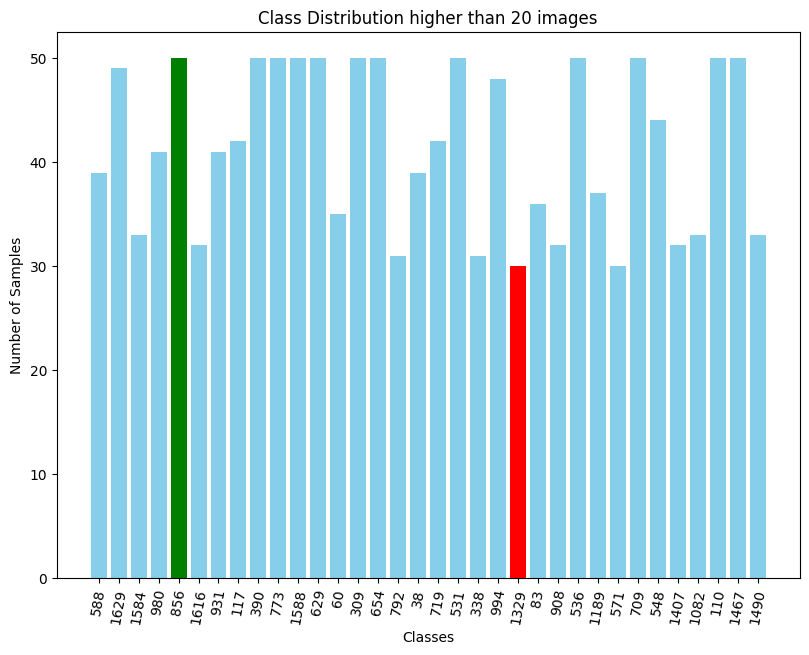

In [5]:
import matplotlib.pyplot as plt

from collections import Counter

def plot(x, y, title:str, color='skyblue', figsize=(8, 6)):
    # Plotting
    plt.figure(figsize=figsize)
    plt.bar(x, y, color=color)
    plt.tight_layout()
    plt.xticks(rotation=800)
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.show()
    
def plot_image_distribution(y, title='Class Distribution higher than 20 images', threshold:int=30, figsize=(8, 6)):
    class_counts = Counter(y)
    
    # Separate major and minor classes
    major_classes = {str(k): v for k, v in class_counts.items() if v >= threshold}
    minor_classes = {str(k): v for k, v in class_counts.items() if v < threshold}
    
    average_minor_classes = sum(minor_classes.values()) / len(minor_classes.values())
    print("Average Minor Classes : {}".format(average_minor_classes))
    
    counts = list(major_classes.values())
    # Find indices of max and min counts
    max_index = counts.index(max(counts))
    min_index = counts.index(min(counts))
    
    # Define colors for bars
    colors = ['skyblue'] * len(counts)  # Default color for all bars
    colors[max_index] = 'green'  # Color for the maximum value bar
    colors[min_index] = 'red'
    
    
    plot(major_classes.keys(), major_classes.values(), title=title, color=colors, figsize=figsize)
    
plot_image_distribution(encoded_y)

In [6]:
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split
# Split into train and test based on class
sorted_image = np.array(sorted_image)
encoded_y = np.array(encoded_y)

skf = StratifiedKFold(n_splits=2)

for i, (train_index, test_index) in enumerate(skf.split(sorted_image, encoded_y)):
    x_train, x_test = sorted_image[train_index], sorted_image[test_index]
    y_train, y_test = encoded_y[train_index], encoded_y[test_index]

Average Minor Classes : 2.048053527980535


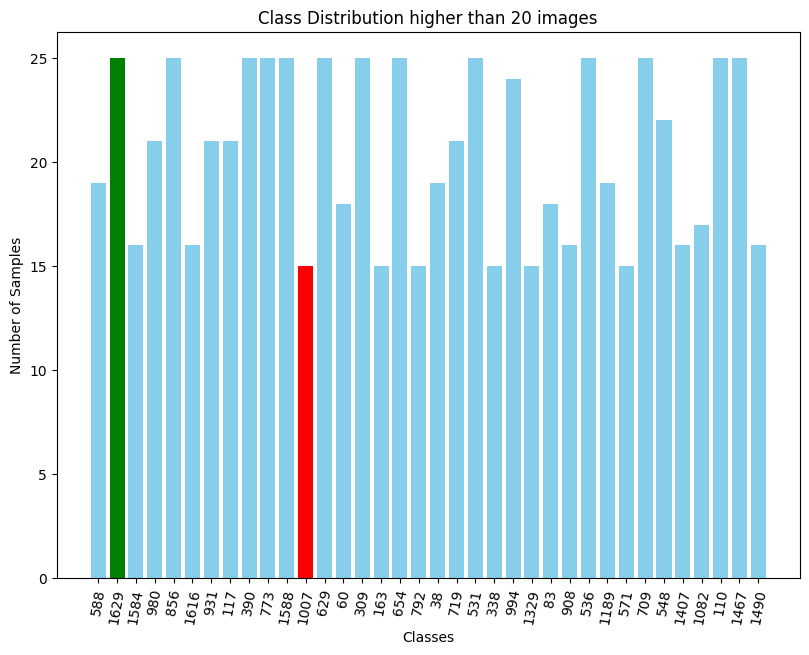

In [7]:
plot_image_distribution(y_train, threshold=15)

In [8]:
minimal_class_amount_augmentation = 15
class_counts = Counter(y_train)

In [9]:
x_augmented, y_augmented = [], []

# Split augmentation
for idx, loaded_image in tqdm.tqdm(enumerate(x_train)):
    current_label = y_train[idx]
    
    # Check if class count bigger than minimal threshold skip, otherwise augment
    class_count = class_counts[current_label]
    if class_count > minimal_class_amount_augmentation:
        x_augmented.append(loaded_image)
        y_augmented.append(current_label)
        continue
    
    # Brightness and horizontal flip|
    bright_image = increase_brightness(loaded_image)
    horizontal_flipped_image = cv2.flip(loaded_image, 1)

    x_augmented.append(loaded_image)
    x_augmented.append(bright_image)
    x_augmented.append(horizontal_flipped_image)
    y_augmented.append(current_label)
    y_augmented.append(current_label)
    y_augmented.append(current_label)

4102it [00:01, 2351.52it/s]


Average Minor Classes : 5.905051734631771


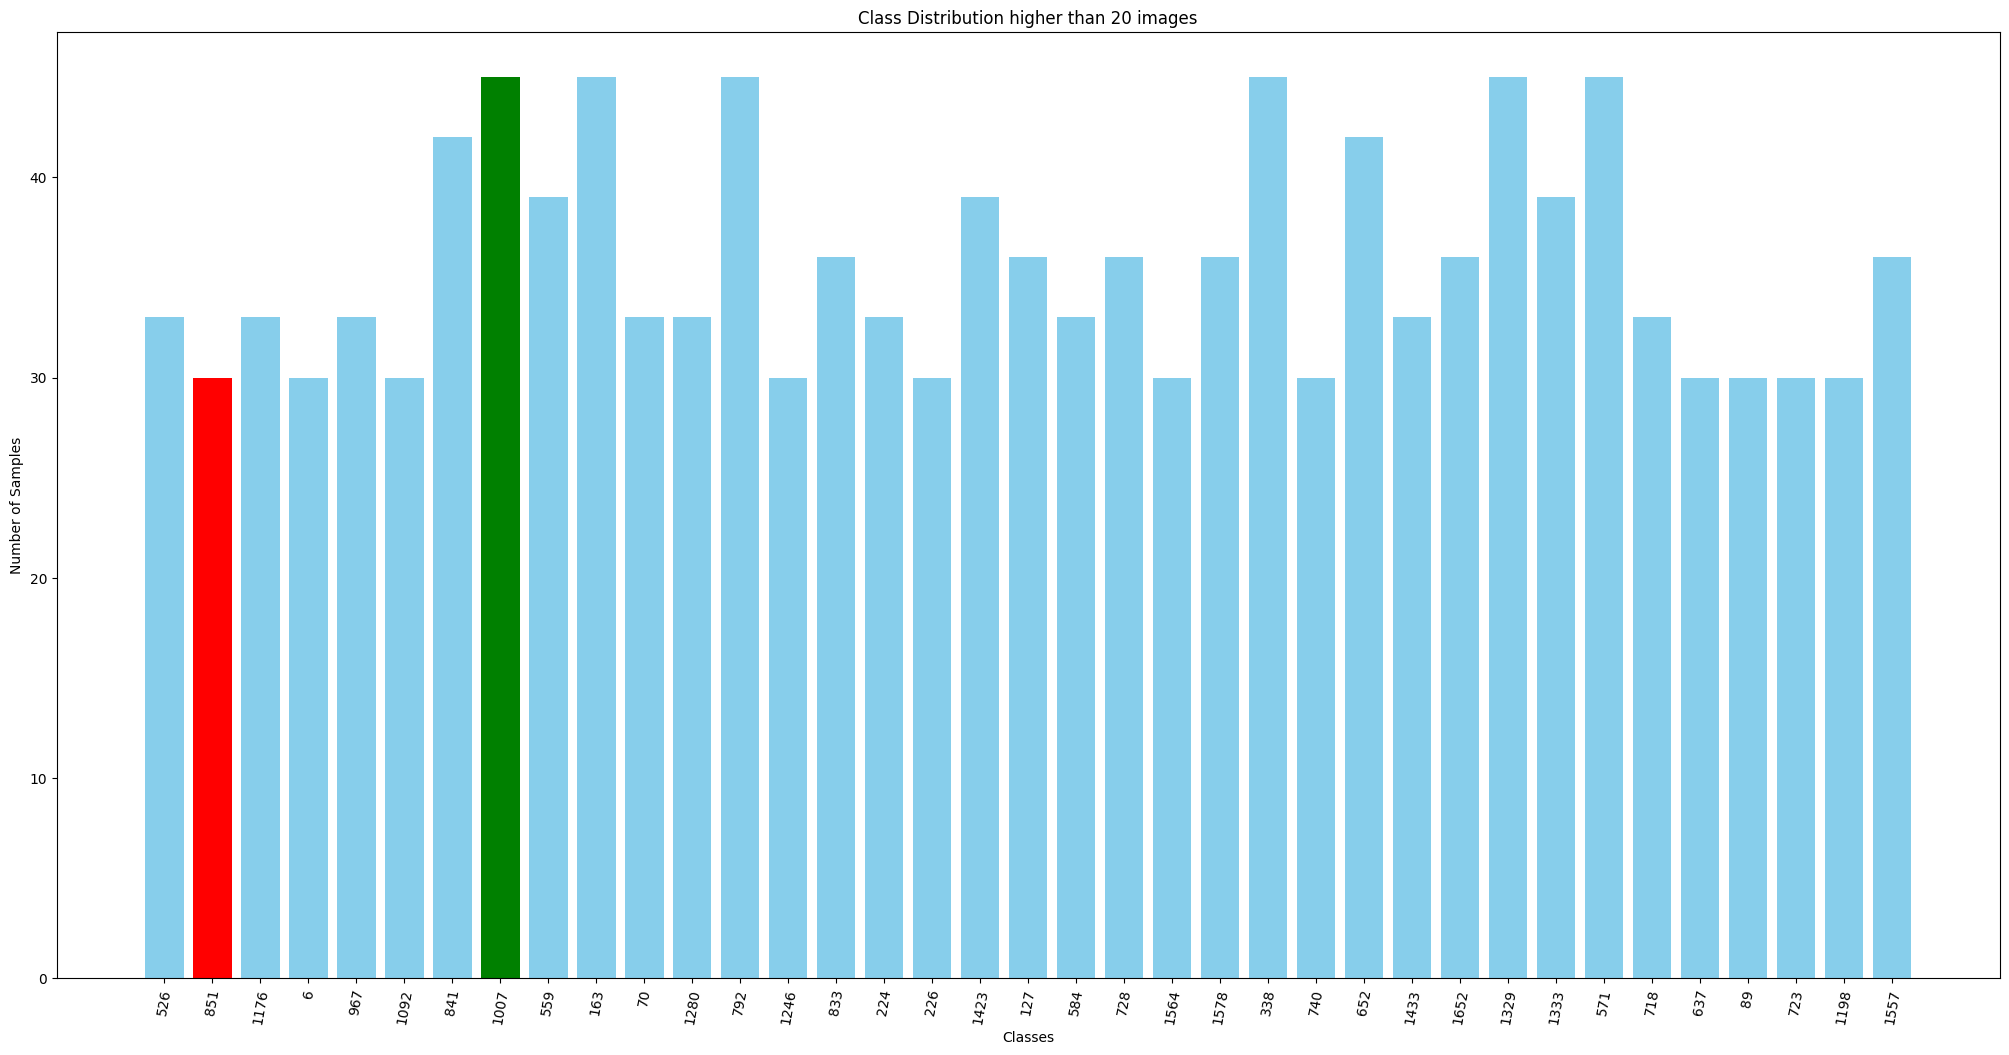

In [10]:
plot_image_distribution(y_augmented, figsize=(20,10))

In [11]:
from module.create_pair import *

x_augmented = np.array(x_augmented)
y_augmented = np.array(y_augmented)

x_train_pairs, y_train_pairs, y_train_anchor, y_train_non_anchor = make_pairs(x_augmented, y_augmented)
x_test_pairs, y_test_pairs, y_test_anchor, y_test_non_anchor = make_pairs(x_test, y_test)

100%|██████████| 4102/4102 [00:00<00:00, 105999.12it/s]


In [12]:
x_train_1 = x_train_pairs[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = x_train_pairs[:, 1]

x_test_1 = x_test_pairs[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = x_test_pairs[:, 1]

In [13]:
import cv2

# Save to numpy and generate
def numpy_save(data_pair, label_pairing, label_anchor, label_non_anchor, set_name:str='train'):
    pair_1, pair_2 = data_pair
    
    # Name config
    # Conevrt image to BGR
    fname_pair_1, fname_pair_2 = [], []
    for idx, pair_image in tqdm.tqdm(enumerate(pair_1)):
        pair_1_conv = pair_1[idx]
        pair_2_conv = pair_2[idx]
        
        name_pair_1, name_pair_2 = "{}_{}_pair_1.png".format(idx, set_name), "{}_{}_pair_2.png".format(idx, set_name)
        
        cv2.imwrite("formatted_dataset/face_recognition/images/" + name_pair_1, pair_1_conv)
        cv2.imwrite("formatted_dataset/face_recognition/images/" + name_pair_2, pair_2_conv)
        
        fname_pair_1.append(name_pair_1)
        fname_pair_2.append(name_pair_2)
        
    #pair_1 = pair_1/255
    #pair_2 = pair_2/255
    
    np.savez(
        'formatted_dataset/face_recognition/{}.npz'.format(set_name),
        pair_1=np.array(fname_pair_1),
        pair_2=np.array(fname_pair_2),
        label_pairing=label_pairing,
        label_anchor=label_anchor,
        label_non_anchor=label_non_anchor
    )

numpy_save(
    data_pair=(x_train_1, x_train_2),
    label_pairing=y_train_pairs,
    label_anchor=y_train_anchor,
    label_non_anchor=y_train_non_anchor,
    set_name='train'
)

numpy_save(
    data_pair=(x_test_1, x_test_2),
    label_pairing=y_test_pairs,
    label_anchor=y_test_anchor,
    label_non_anchor=y_test_non_anchor,
    set_name='test'
)

22032it [03:00, 122.39it/s]
8204it [01:06, 122.96it/s]


540
0.0


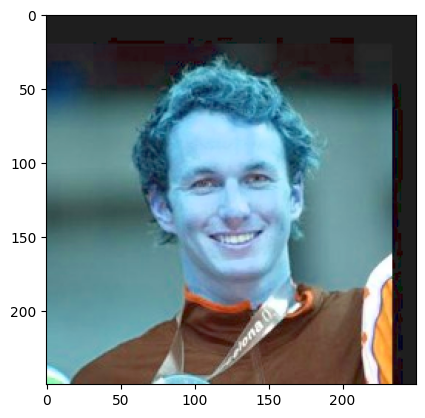

In [43]:
import matplotlib.pyplot as plt

idx = 8
plt.imshow(x_train_1[idx])
print(y_train_anchor[idx])
print(y_train_pairs[idx])

540


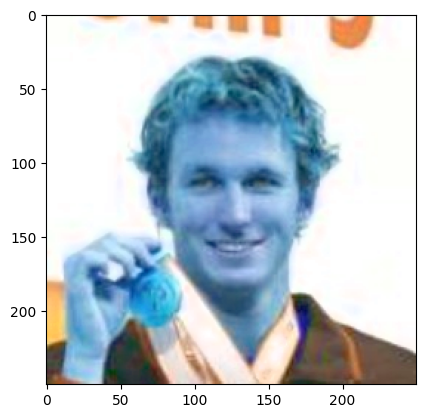

In [44]:
plt.imshow(x_train_2[idx])
print(y_train_non_anchor[idx])